In [1]:
import pandas as pd
import numpy as np

In [2]:
FILE = 'travistorrent_11_1_2017.csv'
#size = 500000
size = 3000000

In [6]:
dataset = pd.read_csv(FILE, sep=',', engine='c',usecols=['gh_team_size','tr_build_id','gh_project_name'],dtype={'gh_team_size': np.int32,
                                                                                                                'tr_build_id': np.float32,
                                                                                                                'gh_project_name': 'category'}
                                                                                                                              , nrows = size, encoding='utf-8')


In [4]:
%%time
dataset = pd.read_csv(FILE, sep=',', engine='c',dtype={'gh_team_size': np.int32,
                                                        'git_num_all_built_commits': np.int32,
                                                        'gh_num_commit_comments': np.int32,
                                                        'git_diff_src_churn': np.int32,
                                                        'git_diff_test_churn': np.int32,
                                                        'gh_diff_files_added': np.int32,
                                                        'gh_diff_files_deleted': np.int32,
                                                        'gh_diff_files_modified': np.int32,
                                                        'gh_diff_tests_added': np.int32,
                                                        'gh_diff_tests_deleted': np.int32,
                                                        'gh_diff_src_files': np.int32,
                                                        'gh_diff_doc_files': np.int32,
                                                        'gh_diff_other_files': np.int32,
                                                        'gh_num_commits_on_files_touched': np.int32,
                                                        'gh_sloc': np.int32,
                                                        'tr_build_number': np.int32,
                                                        'tr_job_id': np.int32,
                                                        'tr_build_id': np.float32,
                                                        'gh_pull_req_num': np.float32,
                                                        'gh_num_commits_in_push': np.float32,
                                                        'tr_prev_build': np.float32,
                                                        'gh_num_issue_comments': np.float32,
                                                        'gh_num_pr_comments': np.float32,
                                                        'gh_test_lines_per_kloc': np.float32,
                                                        'gh_test_cases_per_kloc': np.float32,
                                                        'gh_asserts_cases_per_kloc': np.float32,
                                                        'gh_description_complexity': np.float32,
                                                        'tr_duration': np.float32,
                                                        'tr_log_setup_time': np.float32,
                                                        'tr_log_num_tests_ok': np.float32,
                                                        'tr_log_num_tests_failed': np.float32,
                                                        'tr_log_num_tests_run': np.float32,
                                                        'tr_log_num_tests_skipped': np.float32,
                                                        'tr_log_testduration': np.float32,
                                                        'tr_log_buildduration': np.float32,

                                                        'gh_project_name': 'category',
                                                        'gh_pr_created_at': 'category',
                                                        'gh_lang': 'category',
                                                        'git_merged_with': 'category',
                                                        'git_branch': 'category',
                                                        'gh_commits_in_push': 'category',
                                                        'git_prev_commit_resolution_status': 'category',
                                                        'git_prev_built_commit': 'category',
                                                        'gh_first_commit_created_at': 'category',
                                                        'git_all_built_commits': 'category',
                                                        'git_trigger_commit': 'category',
                                                        'tr_virtual_merged_into': 'category',
                                                        'tr_original_commit': 'category',
                                                        'gh_pushed_at': 'category',
                                                        'gh_build_started_at': 'category',
                                                        'tr_status': 'category',
                                                        'tr_jobs': 'category',
                                                        'tr_log_lan': 'category',
                                                        'tr_log_status': 'category',
                                                        'tr_log_analyzer': 'category',
                                                        'tr_log_frameworks': 'category',
                                                        'tr_log_bool_tests_failed': 'category',
                                                        'tr_log_tests_failed': 'category',


                                                        'gh_is_pr': np.bool,
                                                        'gh_by_core_team_member': np.bool,
                                                        'tr_log_bool_tests_ran': np.bool}

                                                                                          , nrows = size, encoding='utf-8')

'''
Signature:
    sep - separa por virgula
    nrows - limite de linhas lidas
    encoding - tipo de caracter
    engine - Mecanismo do analisador
    na_values - procura os padrões na|nan como str
    keep_default_na - define como nan os padroes econtrados em na_values
    
'''



CPU times: user 57.7 s, sys: 1.94 s, total: 59.7 s
Wall time: 59.5 s


<font size=4/>
   * Elimia as colunas não utilizadas

In [6]:
# Eliminando colunas - 
dataset.drop([  'gh_diff_files_added',
                'gh_commits_in_push',
                'gh_diff_files_deleted',
                'gh_diff_files_modified',
                'gh_diff_tests_added',
                'gh_diff_tests_deleted',
                'gh_diff_src_files',
                'gh_diff_doc_files',
                'gh_diff_other_files',
                'gh_sloc',
                'gh_test_lines_per_kloc',
                'gh_test_cases_per_kloc',
                'gh_pull_req_num',
                'gh_description_complexity',
                'git_merged_with',
                'gh_asserts_cases_per_kloc',
              
                'git_prev_built_commit',
              
                'tr_log_status',
                'tr_status',
                'tr_job_id',
                'tr_jobs',
                'tr_build_number',
                'tr_duration',
                'tr_log_lan',
                'tr_log_num_tests_run',
                'tr_log_setup_time',
                'tr_log_analyzer',
                'tr_log_frameworks',
                'tr_log_bool_tests_ran',
                'tr_log_bool_tests_failed',
                'tr_log_tests_failed',
                'tr_log_testduration',
                'tr_log_buildduration'], axis=1, inplace=True)

In [8]:
df_ruby = dataset.dropna() # Remove as linhas NAN

df_ruby['date'], df_ruby['hours'] = df_ruby.gh_pushed_at.str.split(' ').str # Separa a coluna que possui data e hora em duas novas colunas de data hora

/home/wagner/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [7]:
projects = dataset.drop_duplicates(['gh_project_name'])
projects = projects.loc[projects['gh_lang']=='ruby']
projects = projects.gh_project_name


* Taxa de commit por participante no projeto- Quantidade total de commits / Quantidade total de participantes

In [65]:
def rate_commit(projects):
    list_project_name = []
    list_rate_commit = []
    
    for project_name in projects:
        # Define projeto
        df_ruby = dataset.loc[dataset['gh_project_name'] == project_name] # Filtro penas o projeto
        #df_ruby = df_ruby.dropna() # Remove as linhas NaN
        
        # Remove linhas duplicadas
        df_ruby = df_ruby.drop_duplicates(['tr_build_id']) # remove as linhas duplicadas
        start_build = df_ruby['tr_build_id'] # cria uma serie com os ids das builds unicas do projeto
        
        
        # Soma de todos push
        num_commit = df_ruby.gh_num_commits_in_push.sum() 
        
        # Quantidade de contribuidores do projeto
        team_size = int(df_ruby.gh_team_size.head(1))
         

        if((num_commit != 0) and (team_size != 0)):
            # Media projeto
            mean_project = len(start_build)/team_size
            
            # Taxa commit
            taxa_commit = (num_commit/ mean_project)
            
            list_rate_commit.append(taxa_commit)
            list_project_name.append(project_name)
    return(list_rate_commit, list_project_name)

In [83]:
def project_frequency(list_rate_commit, list_project_name):
    low_frequency = []
    medium_frequency = []
    high_frequency = []
    
    for i in range(len(list_rate_commit)):
        if(list_rate_commit[i] < 8):
            low_frequency.append(list_project_name[i])
            
        elif((list_rate_commit[i] > 8) and (list_rate_commit[i] < 25)) :
            medium_frequency.append(list_project_name[i])
            
        else:
            high_frequency.append(list_project_name[i])
            
            
    return(low_frequency, medium_frequency, high_frequency)

In [84]:
list_rate_commit, list_project_name = rate_commit(projects)

In [85]:
low, medium, high = project_frequency(list_rate_commit, list_project_name)

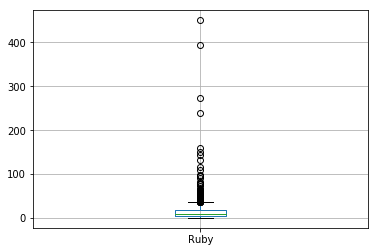

In [70]:
df = pd.DataFrame(list_rate_commit, columns=['Ruby'])

df.boxplot(column=['Ruby'])